# MNIST dataset classification

Here I'm training a neural network to solve the "Hello world" of image recognition. 28x28 pixel monochrome images of handwritten digits 0...9.

I'm using ensembling of 3 different neural networks, each having different weaknesses shown in confusion matrices.

Good enough to get 99.685% accuracy on Kaggle competition https://www.kaggle.com/c/digit-recognizer/leaderboard

Dataset can be found on kaggle as well.

In [1]:
EPOCHS = 70

# 1. Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.scale as scale
import seaborn as sns
%matplotlib inline
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, Input
from keras.layers import Activation, Dense, Conv2D, Flatten, pooling, Dropout, \
                        GlobalAveragePooling2D, Average, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# 2. Load, reshape and split data
### train.csv and test.csv from Kaggle MNIST competition need to be in the same folder as the notebook

In [3]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y = df.loc[:,'label'].values
X = df.loc[:,'pixel0':'pixel783'].values

In [5]:
print(X.shape)
print(Y.shape)

(42000, 784)
(42000,)


In [6]:
#reshape data to fit model
X = X.reshape(len(X),28,28,1)

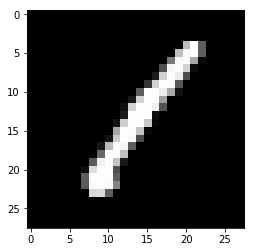

In [7]:
#plot the first image in the dataset
plt.imshow(X[0].reshape(28,28), cmap='gray')

In [8]:
#one-hot encode target column
Y = to_categorical(Y)
print(Y[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1) # <<-- do that for each model training separately

# 3. Preprocess data

Here I'm generating slight variations of original images for each iteration to reduce overfitting and to learn more general representation of categories.

In [10]:
# rotations, translations, zoom
image_generator = ImageDataGenerator(
    rotation_range = 10, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    zoom_range = 0.1)
#image_generator.fit(X_train)

# 4. Create models

In [11]:
input_shape = X[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [12]:
def model_cpga(model_input):
    #add model layers
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same')(model_input)
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = pooling.MaxPool2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = pooling.MaxPool2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(192, kernel_size=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(10, kernel_size=(1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    #create model
    model = Model(model_input, x, name='ConvPool-GlobalAverage')
    return model

In [13]:
def model_convpool():
    #add model layers
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(model_input)
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = pooling.MaxPool2D()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = pooling.MaxPool2D()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = pooling.MaxPool2D()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)
    
    #create model
    model = Model(model_input, x, name='ConvPool')
    return model

In [14]:
def model_convpool2():
    #add model layers
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(model_input)
    x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    x = pooling.MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = pooling.MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = pooling.MaxPool2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)
    
    #create model
    model = Model(model_input, x, name='ConvPool2')
    return model

# 5. Compile and train

In [15]:
def compile_and_train(model, num_epochs, seed):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=1e-9)
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    flow = image_generator.flow(X_train, y_train, batch_size=32)
    history = model.fit_generator(flow, steps_per_epoch=len(X_train) / 32, epochs=num_epochs, 
                            validation_data=(X_test, y_test), verbose=1, callbacks=[learning_rate_reduction])
    return history

In [16]:
def plot_training(history):
    # loss
    fig, axs = plt.subplots(1, 2, figsize=(20,7))
    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].legend()
    axs[0].set_yscale('log')

    # accuracies
    axs[1].plot(1 - np.array(history.history['acc']), label='1 - acc')
    axs[1].plot(1 - np.array(history.history['val_acc']), label='1 - val_acc')
    axs[1].legend()
    axs[1].set_yscale('log')

In [17]:
model1 = model_cpga(model_input)
r1 = compile_and_train(model1, EPOCHS, 1)

Epoch 1/70
1181/1181 [==============================] - 46s 39ms/step - loss: 0.3042 - acc: 0.9036 - val_loss: 0.0512 - val_acc: 0.9838
Epoch 2/70
1181/1181 [==============================] - 44s 38ms/step - loss: 0.0687 - acc: 0.9786 - val_loss: 0.0621 - val_acc: 0.9817
Epoch 3/70
1181/1181 [==============================] - 44s 38ms/step - loss: 0.0467 - acc: 0.9856 - val_loss: 0.0245 - val_acc: 0.9924
Epoch 4/70
1181/1181 [==============================] - 44s 38ms/step - loss: 0.0365 - acc: 0.9893 - val_loss: 0.0242 - val_acc: 0.9919
Epoch 5/70
1181/1181 [==============================] - 44s 38ms/step - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0279 - val_acc: 0.9919
Epoch 6/70
1181/1181 [==============================] - 44s 38ms/step - loss: 0.0281 - acc: 0.9917 - val_loss: 0.0236 - val_acc: 0.9929
Epoch 7/70
1181/1181 [==============================] - 44s 38ms/step - loss: 0.0226 - acc: 0.9927 - val_loss: 0.0211 - val_acc: 0.9933
Epoch 8/70
1181/1181 [==========================

1181/1181 [==============================] - 45s 38ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0195 - val_acc: 0.9955
Epoch 55/70
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0195 - val_acc: 0.9955
Epoch 56/70
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0195 - val_acc: 0.9955

Epoch 00056: ReduceLROnPlateau reducing learning rate to 6.10351547081e-09.
Epoch 57/70
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0195 - val_acc: 0.9955
Epoch 58/70
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0023 - acc: 0.9992 - val_loss: 0.0195 - val_acc: 0.9955
Epoch 59/70
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0195 - val_acc: 0.9955

Epoch 00059: ReduceLROnPlateau reducing learning rate to 3.05175773541e-09.
Epoch 60/70
1181/1181 [=============

In [18]:
model2 = model_convpool()
r2 = compile_and_train(model2, EPOCHS, 2)

Epoch 1/70
1181/1181 [==============================] - 30s 25ms/step - loss: 0.4108 - acc: 0.8676 - val_loss: 0.0800 - val_acc: 0.9757
Epoch 2/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.1002 - acc: 0.9691 - val_loss: 0.0603 - val_acc: 0.9812
Epoch 3/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0783 - acc: 0.9764 - val_loss: 0.0379 - val_acc: 0.9893
Epoch 4/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0566 - acc: 0.9832 - val_loss: 0.0381 - val_acc: 0.9895
Epoch 5/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0481 - acc: 0.9853 - val_loss: 0.0308 - val_acc: 0.9914
Epoch 6/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0428 - acc: 0.9868 - val_loss: 0.0313 - val_acc: 0.9912
Epoch 7/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0373 - acc: 0.9890 - val_loss: 0.0228 - val_acc: 0.9926
Epoch 8/70
1181/1181 [==========================

1181/1181 [==============================] - 29s 24ms/step - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0180 - val_acc: 0.9957
Epoch 55/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0180 - val_acc: 0.9957
Epoch 56/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0085 - acc: 0.9972 - val_loss: 0.0180 - val_acc: 0.9957

Epoch 00056: ReduceLROnPlateau reducing learning rate to 6.10351547081e-09.
Epoch 57/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0180 - val_acc: 0.9957
Epoch 58/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0080 - acc: 0.9975 - val_loss: 0.0180 - val_acc: 0.9957
Epoch 59/70
1181/1181 [==============================] - 29s 24ms/step - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0180 - val_acc: 0.9957

Epoch 00059: ReduceLROnPlateau reducing learning rate to 3.05175773541e-09.
Epoch 60/70
1181/1181 [=============

In [19]:
model3 = model_convpool2()
r3 = compile_and_train(model3, EPOCHS, 3)

Epoch 1/70
1181/1181 [==============================] - 34s 29ms/step - loss: 0.4622 - acc: 0.8627 - val_loss: 0.1829 - val_acc: 0.9514
Epoch 2/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.1611 - acc: 0.9540 - val_loss: 0.0964 - val_acc: 0.9740
Epoch 3/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.1188 - acc: 0.9666 - val_loss: 0.0464 - val_acc: 0.9876
Epoch 4/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0946 - acc: 0.9726 - val_loss: 0.0554 - val_acc: 0.9838
Epoch 5/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0801 - acc: 0.9766 - val_loss: 0.0350 - val_acc: 0.9898
Epoch 6/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0718 - acc: 0.9794 - val_loss: 0.0409 - val_acc: 0.9879
Epoch 7/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0637 - acc: 0.9814 - val_loss: 0.0451 - val_acc: 0.9874
Epoch 8/70
1181/1181 [==========================

1181/1181 [==============================] - 32s 27ms/step - loss: 0.0313 - acc: 0.9900 - val_loss: 0.0227 - val_acc: 0.9933

Epoch 00053: ReduceLROnPlateau reducing learning rate to 3.05175773541e-09.
Epoch 54/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0296 - acc: 0.9907 - val_loss: 0.0227 - val_acc: 0.9938
Epoch 55/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0305 - acc: 0.9901 - val_loss: 0.0226 - val_acc: 0.9933
Epoch 56/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0298 - acc: 0.9909 - val_loss: 0.0223 - val_acc: 0.9936

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.5258788677e-09.
Epoch 57/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0287 - acc: 0.9907 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 58/70
1181/1181 [==============================] - 32s 27ms/step - loss: 0.0326 - acc: 0.9900 - val_loss: 0.0225 - val_acc: 0.9938
Epoch 59/70
1181/1181 [==============

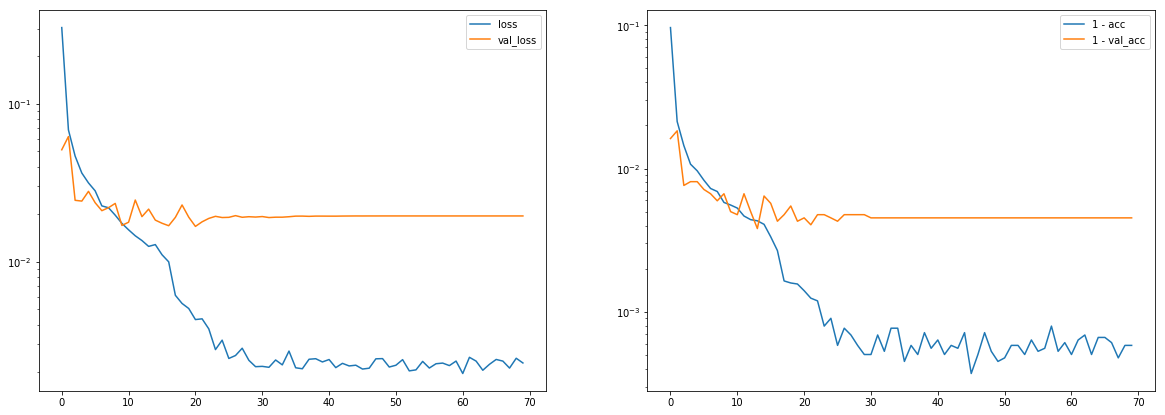

In [20]:
plot_training(r1)

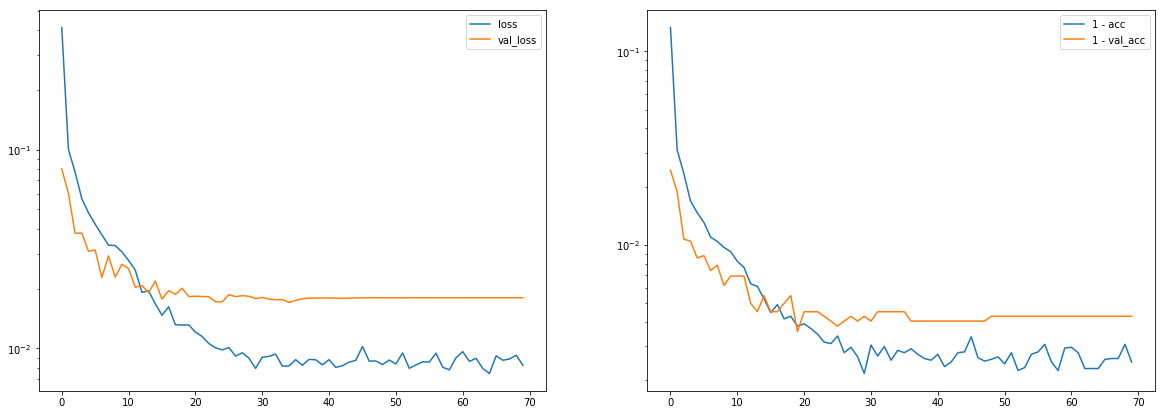

In [21]:
plot_training(r2)

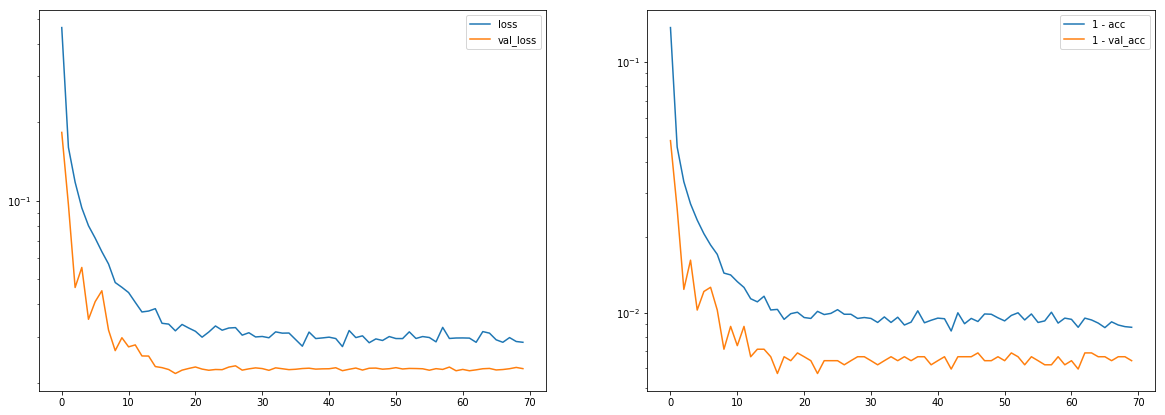

In [22]:
plot_training(r3)

# 6. Analyzing results

Confusion matrices look different enough to hope for good results from ensembling.

In [23]:
def print_confusion_matrix(model, seed, split=0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)
    preds = model.predict(X_test).argmax(axis=1)
    conf_mat = confusion_matrix(y_test.argmax(axis=1), preds)
    df_cm = pd.DataFrame(conf_mat, index = [str(i) for i in range(10)],
                  columns = [str(i) for i in range(10)])
    for i in range(df_cm.shape[0]):
        df_cm.iloc[i, i] = -1
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)

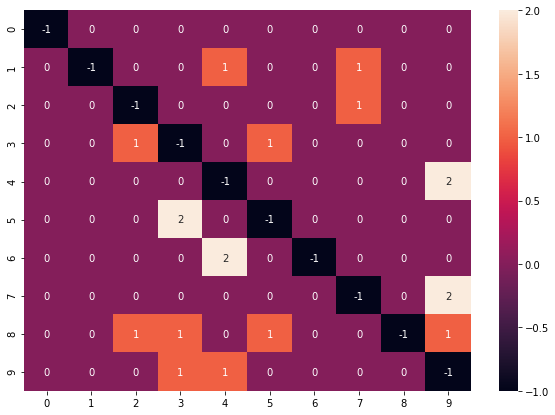

In [24]:
print_confusion_matrix(model1, 1)

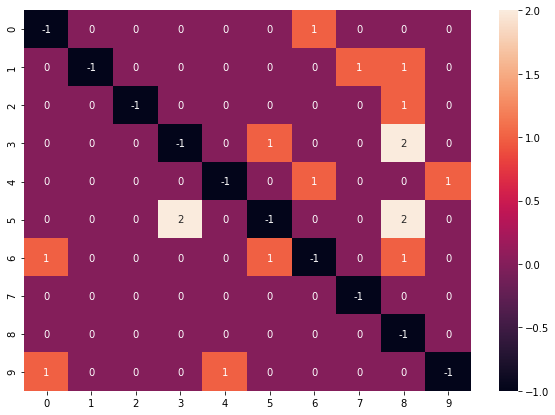

In [25]:
print_confusion_matrix(model2, 2)

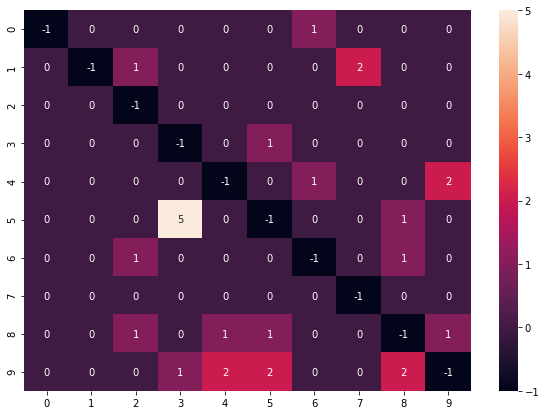

In [26]:
print_confusion_matrix(model3, 3)

In [27]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model

In [28]:
ensemble_model = ensemble([model1, model2, model3], model_input)

### Here I'm using the whole dataset to evaluate the ensemble model

Single model confusion matrices are on test split only

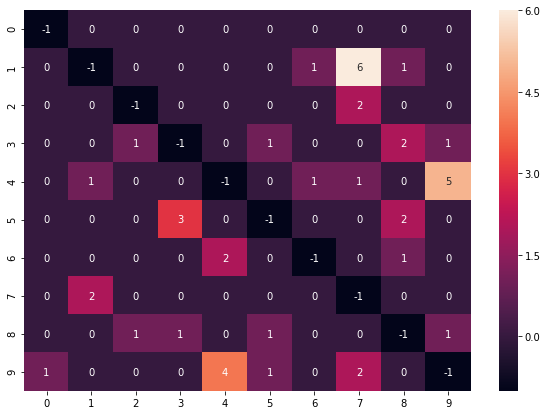

In [29]:
print_confusion_matrix(ensemble_model, 1, split=.9999999)

In [30]:
def evaluate_error(model):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.9999999, random_state=1)
    pred = model.predict(X_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    error = np.mean(pred != np.argmax(y_test, axis=1)) 
    print(error)

In [31]:
evaluate_error(model1)
evaluate_error(model2)
evaluate_error(model3)
evaluate_error(ensemble_model)

0.0007380952380952381
0.0014285714285714286
0.003119047619047619
0.0010714285714285715


# 7. Finally let's predict on test set and generate the answers .csv

In [32]:
df_test = pd.read_csv('test.csv')

In [33]:
X = df_test.values

In [34]:
X = X.reshape(len(X),28,28,1)

In [35]:
p = ensemble_model.predict(X)

In [36]:
answers = p.argmax(axis=1)

In [37]:
df = pd.DataFrame(answers, index=np.arange(1,28001), columns=['Label'])

In [38]:
df['ImageId'] = df.index

In [39]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,0
5,5,3


In [40]:
df.to_csv('answers.csv', index=False)